In [1]:
from mazelib import *
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from dataset import *

import random
random.seed(7)

#### Problem definition
    
    Inputs:
        - Maze start and end points
        - Maze (drivable non drivable area) /  not necessary as long the supervision exist
        - Mazes should be generated by difficulty and should be unique
        
    Outputs:
        - x, y future coordinates of the agent (one move)
        - The number of moves to solve the maze is variable
        - A grid is generated using the predicted coordinates and the agent size
    
    Losses:
        - Imitation Loss, RMSE
        - Path planning loss, overlap between predicted ego and desired path planning
        - Maze loss, overlap between predicted ego and maze walls (do not hit or traverse)
        - Start/ end loss: overlap of the FIRST and LAST sequence points with the maze's entrance and exit
        
    Notes:
        - We study the effect of dopping (%) on non-valid trajectories on the agent's behavior
        
        
### Create dataset


In [2]:
me = MazeExplorer(maze_size=(64,64), nbr_instances=100, difficulty='mixed', nbr_trajectories=15)

100%|██████████| 16/16 [00:00<00:00, 1201.35it/s]

Creating MazeExplorer dataset of difficulty mixed
Using Prims generator
Using shortest path solver



100%|██████████| 16/16 [00:00<00:00, 261.64it/s]


Dataset generated... 1536 available instances


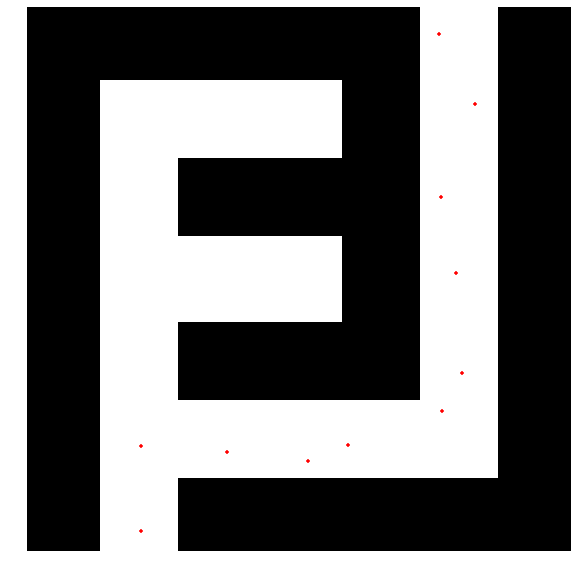

In [3]:
plot_solution(me[232][0], me[232][4])

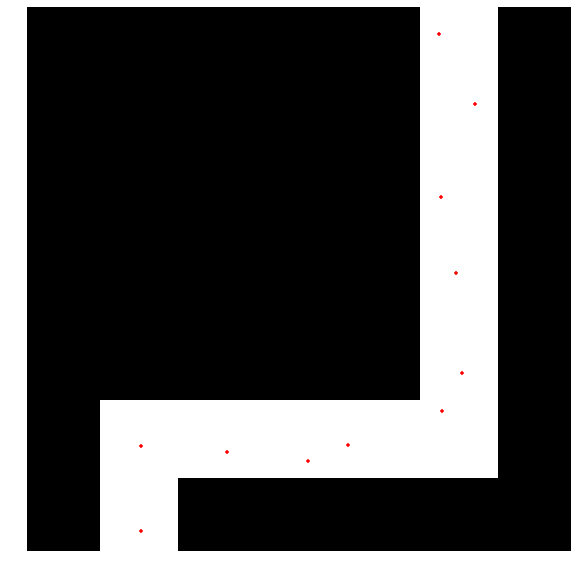

In [4]:
plot_solution(me[232][1], me[232][4])

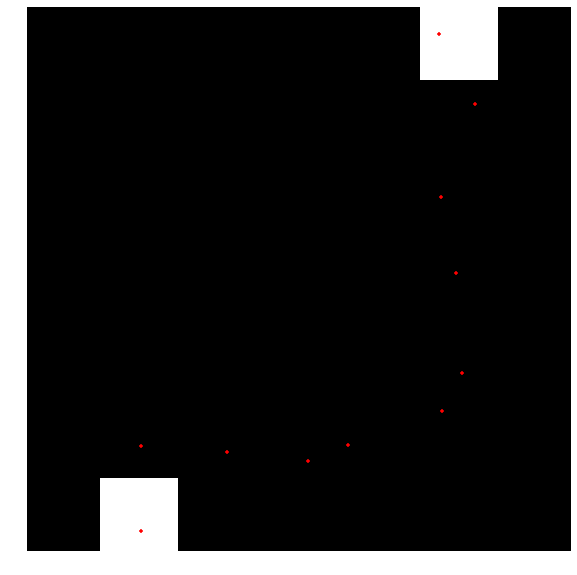

In [5]:
plot_solution(me[232][2], me[232][4])

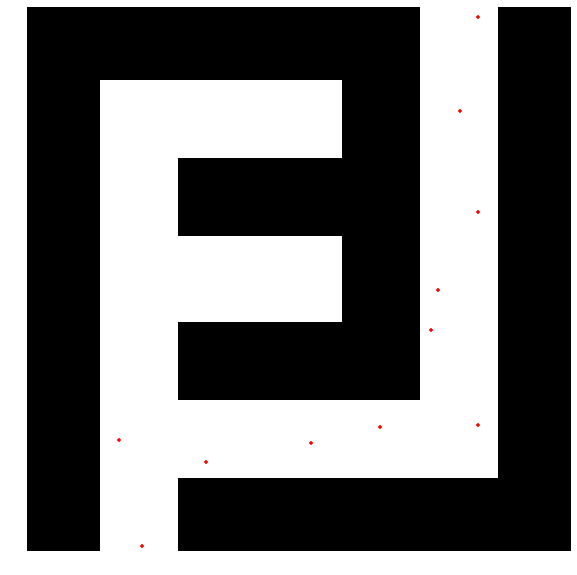

In [6]:
plot_solution(me[233][0], me[233][4])

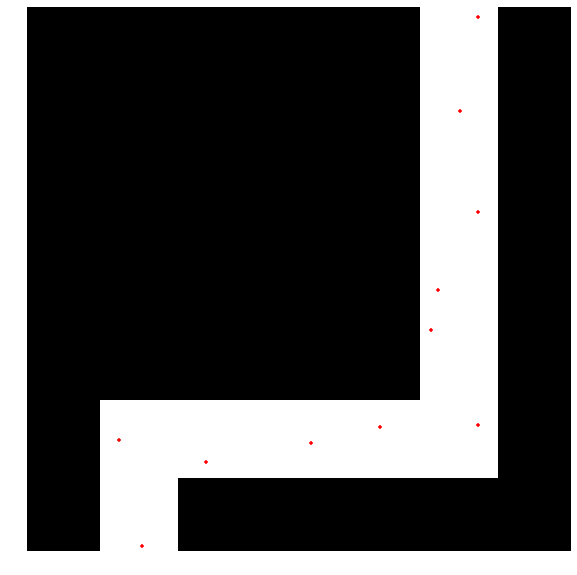

In [7]:
plot_solution(me[233][1], me[233][4])

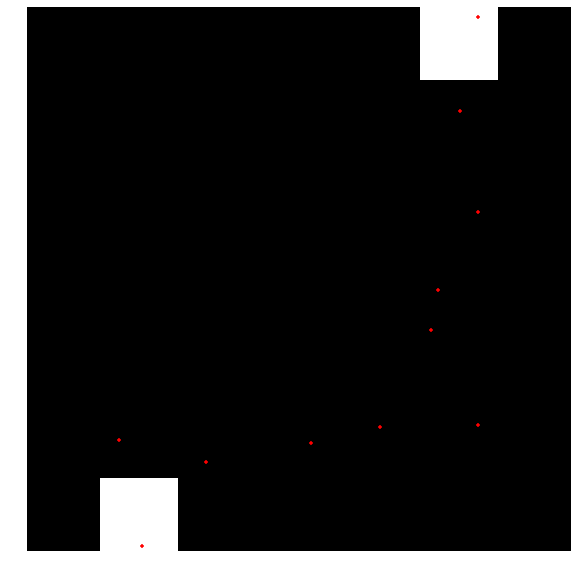

In [8]:
plot_solution(me[233][2], me[233][4])

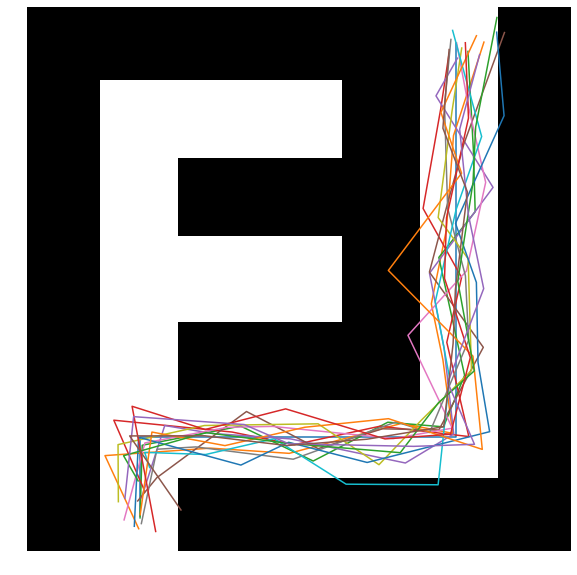

In [9]:
plot_trajectories(me[235][0], me[235][5])

In [10]:
family = generate_family_trajectories(me[800][5][0], 10, 4)
grid = me[800][0]
path = me[800][1]
goal = me[800][2]
tr = family[5]

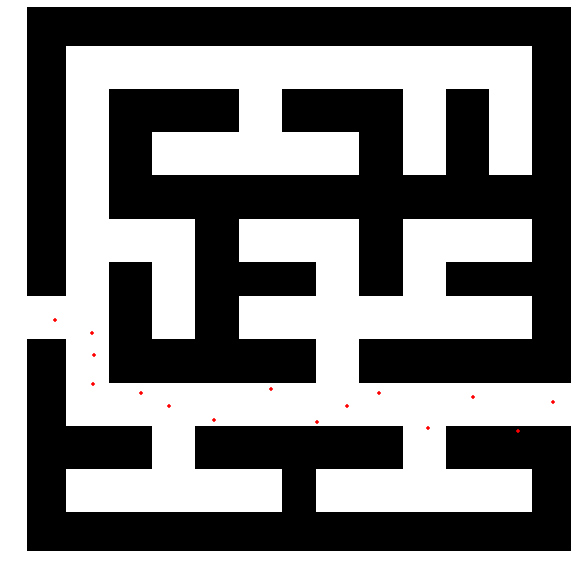

In [11]:
plot_solution(grid, tr)

In [12]:
estimate_road_width(grid)

4

In [13]:
estimate_road_width(path)

4

In [14]:
estimate_road_width(goal)

4

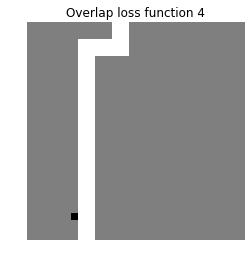

<Figure size 720x720 with 0 Axes>

In [15]:
play_raw_data(path, tr, 3)

In [16]:
check_trajectory(tr, path, 3)

(4, 15)

In [17]:
me.len()

1536

In [18]:
me.get_dopping_percentage()

100%|██████████| 1536/1536 [01:00<00:00, 25.34it/s]

Estimated dopping percentage =  9.633


9.633

### To do
    - Covariance vs dopping function
    - Is the last trajectory point appended?
    - Why do I need to transpose the grid when computing the Loss?
    - Goals loss function needs to be taylor (otherwise will punish a lot)
    - Shall we add some mapping weights to loss function?
    - Write final loss function in PyTorch
    